In [1]:
from utils import QuantumDotFET

from diamondminer.utils import *
from diamondminer.miner import * 

Detectron2 not found on the system cannot run any segmentation models.


# Connect to Tuner Class

In [2]:
QD_FET_Tuner = QuantumDotFET(
    config='config-files/config.yaml',
    tuner_config='config-files/fet_tuner_config.yaml',
    station_config='config-files/station_config.yaml',
    save_dir='C:\\Users\\coher\\Desktop\\noise1\\noise2'
)

2024-09-25 18:31:45,416 - utils - ATTEMPT connecting to station
Connected to: Stanford_Research_Systems SIM900 (serial:s/n130900, firmware:ver3.6) in 1.58s
Connected to: HEWLETT-PACKARD 34401A (serial:0, firmware:11-5-3) in 0.06s
2024-09-25 18:31:49,158 - utils - COMPLETE 

2024-09-25 18:31:49,158 - utils - INFO changing parameters to match names in config.yaml file
2024-09-25 18:31:49,158 - utils - INFO changed volt_3 to LB
2024-09-25 18:31:49,168 - utils - INFO changed volt_5 to RB
2024-09-25 18:31:49,168 - utils - INFO changed volt_6 to L
2024-09-25 18:31:49,168 - utils - INFO changed volt_8 to S
2024-09-25 18:31:49,180 - utils - INFO changed volt_4 to P
2024-09-25 18:31:49,835 - utils - INFO database created/loaded @ C:\Users\coher\Desktop\noise1\noise2\n45_d13_2024-09-25\experiments_n45_d13_2024-09-25.db
2024-09-25 18:31:49,835 - utils - INFO experiment created/loaded in database
2024-09-25 18:31:49,892 - utils - INFO copying all of the config.yml files
2024-09-25 18:31:49,895 - u

Optional: Monitoring your variables

In [ ]:
# !python -m qcodes.monitor.monitor
# monitor = qc.Monitor(
#     QD_FET_Tuner.drain_volt, 
#     QD_FET_Tuner.voltage_source.S, 
#     QD_FET_Tuner.voltage_source.L,
#     QD_FET_Tuner.voltage_source.LB,
#     QD_FET_Tuner.voltage_source.P,
#     QD_FET_Tuner.voltage_source.RB,
#     )
# monitor.show()

In [3]:
QD_FET_Tuner.ground_device()

2024-09-25 18:32:05,685 - utils - ATTEMPT grounding device
2024-09-25 18:32:06,367 - utils - COMPLETE 



# 0. Bias Device 

In [4]:
QD_FET_Tuner.bias_ohmic(
    ohmic='S', 
    V=0.01
) 

2024-09-25 18:32:09,856 - utils - ATTEMPT setting ohmic (S) to 0.01 V
2024-09-25 18:32:09,856 - utils - INFO device receives 0.1 mV based on divider
2024-09-25 18:32:10,039 - utils - COMPLETE 



# 1. Turn On Device

2024-09-25 18:32:14,600 - utils - INFO setting ['LB', 'RB', 'L'] to 0 V
2024-09-25 18:32:15,058 - utils - ATTEMPT sweeping ['LB', 'RB', 'L'] together from 0 V to 2.5 V
Starting experimental run with id: 1. Using 'qcodes.dataset.dond'


  0%|          | 0/101 [00:00<?, ?it/s]

An exception occurred in measurement with guid: e3e18d88-0000-0000-0000-01922b5049f6;
Traceback:
Traceback (most recent call last):
  File "c:\Users\coher\Documents\GitHub\QuantumDotControl\.venv\lib\site-packages\qcodes\dataset\dond\do_nd.py", line 753, in dond
    raise BreakConditionInterrupt("Break condition was met.")
qcodes.dataset.dond.do_nd_utils.BreakConditionInterrupt: Break condition was met.

Measurement has been interrupted, data may be incomplete: Break condition was met.


2024-09-25 18:32:29,699 - utils - COMPLETE 

2024-09-25 18:32:30,792 - utils - INFO Fit params: a = -1.2036836660433976e-09, b = 1.415092925477087, x0 = 1.543788443502922, y0 = -2.108313361470805e-09
2024-09-25 18:32:30,845 - utils - INFO device turns on at 1.666 V
2024-09-25 18:32:30,845 - utils - INFO maximum allowed voltage is 1.95 V
2024-09-25 18:32:30,845 - utils - INFO measured current is 1.6336158e-09 A
2024-09-25 18:32:30,845 - utils - INFO calculated resistance is 61213.904 Ohms


c:\Users\coher\Documents\GitHub\QuantumDotControl\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


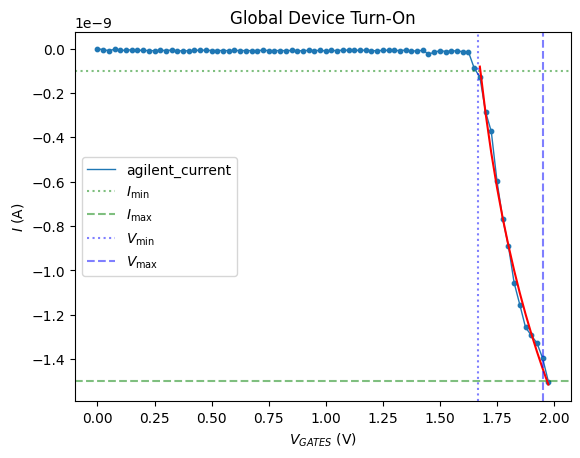

In [5]:
turn_on_data = QD_FET_Tuner.turn_on(
    minV=0, 
    maxV=None,
    dV=0.025
)

# 2. Pinch Off Gate(s)

In [ ]:
# QD_FET_Tuner.deviceTurnsOn=True

# QD_FET_Tuner.results['turn_on']['voltage'] = -2
# QD_FET_Tuner.results['turn_on']['saturation'] = -3


2024-09-25 18:32:49,070 - utils - INFO setting voltage configuration: {'L': 2.1}
2024-09-25 18:32:49,956 - utils - INFO setting ['LB', 'RB'] to 1.95 V
2024-09-25 18:32:50,385 - utils - ATTEMPT pinching off LB from 1.95 V to 0.0 V
Starting experimental run with id: 2. Using 'qcodes.dataset.dond'


  0%|          | 0/391 [00:00<?, ?it/s]

2024-09-25 18:33:17,427 - utils - COMPLETE 

2024-09-25 18:33:17,427 - utils - INFO returning LB to 1.95 V
2024-09-25 18:33:29,118 - utils - INFO LB, fitting data to sigmoid
2024-09-25 18:33:29,261 - utils - INFO Fit params: a = 2.0731218268750714e-09, b = 54.70149469247488, x0 = 0.7013457546261526, y0 = -2.069043667221319e-09
2024-09-25 18:33:29,268 - utils - INFO LB, pinch off at 0.65
2024-09-25 18:33:29,268 - utils - INFO LB, pinch off width of 0.1
2024-09-25 18:33:29,485 - utils - ATTEMPT pinching off RB from 1.95 V to 0.0 V
Starting experimental run with id: 3. Using 'qcodes.dataset.dond'


  0%|          | 0/391 [00:00<?, ?it/s]

2024-09-25 18:33:57,281 - utils - COMPLETE 

2024-09-25 18:33:57,283 - utils - INFO returning RB to 1.95 V
2024-09-25 18:34:09,017 - utils - INFO RB, fitting data to sigmoid
2024-09-25 18:34:09,122 - utils - INFO Fit params: a = -2.088534578773213e-09, b = -36.60422855714414, x0 = 0.7719097348599506, y0 = 4.5151133540086385e-12
2024-09-25 18:34:09,135 - utils - INFO RB, pinch off at 0.695
2024-09-25 18:34:09,135 - utils - INFO RB, pinch off width of 0.15


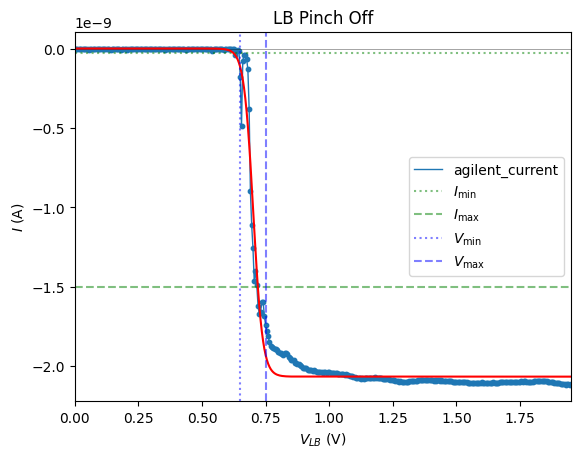

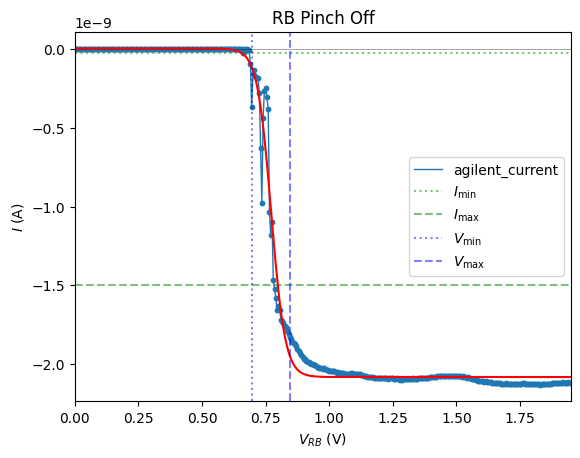

In [6]:
pinch_off_data = QD_FET_Tuner.pinch_off(
    gates=["LB", "RB"],
    minV=None, 
    maxV=None, 
    dV=0.005,
    voltage_configuration={"L": 2.1}
)

In [ ]:
# QD_FET_Tuner.results['LB']['pinch_off']['voltage'] = -2
# QD_FET_Tuner.results['LB']['pinch_off']['width'] = 0.5
# QD_FET_Tuner.results['RB']['pinch_off']['voltage'] = -2
# QD_FET_Tuner.results['RB']['pinch_off']['width'] = 0.5

# 3. Barrier Barrier Sweep

2024-09-25 18:37:29,497 - utils - INFO setting voltage configuration: {'L': 2.1}
2024-09-25 18:37:29,668 - utils - INFO setting LB to 0.71 V
2024-09-25 18:37:29,668 - utils - INFO setting RB to 0.785 V
2024-09-25 18:37:37,738 - utils - ATTEMPT barrier barrier scan
2024-09-25 18:37:37,738 - utils - INFO stepping LB from 0.71 V to 0.65 V
2024-09-25 18:37:37,738 - utils - INFO sweeping RB from 0.785 V to 0.695 V
Starting experimental run with id: 4. Using 'qcodes.dataset.do2d'


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

2024-09-25 18:44:46,416 - utils - COMPLETE 

2024-09-25 18:44:46,416 - utils - INFO returning gates LB, RB to 0.71 V, 0.785 V respectively


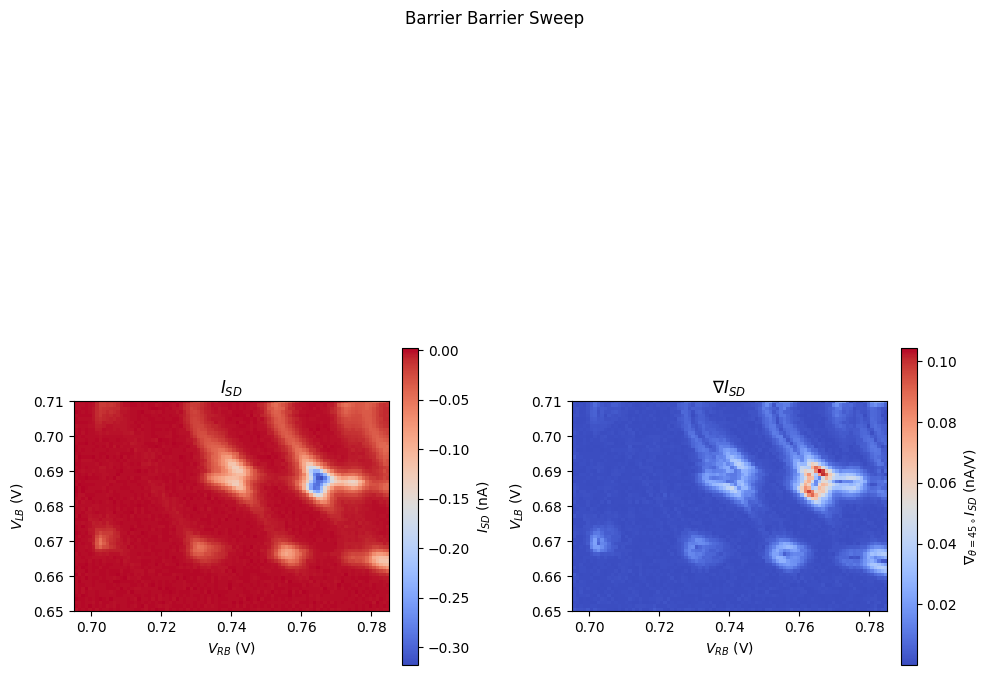

In [7]:
df, current_axes = QD_FET_Tuner.sweep_barriers(
    B1='LB', 
    B2='RB', 
    B1_bounds=(0.65, 0.71),
    B2_bounds=(0.695, 0.785),
    dV=0.001,
    voltage_configuration={"L": 2.1},
    extract_bias_point=False
)

Extract Bias Point 

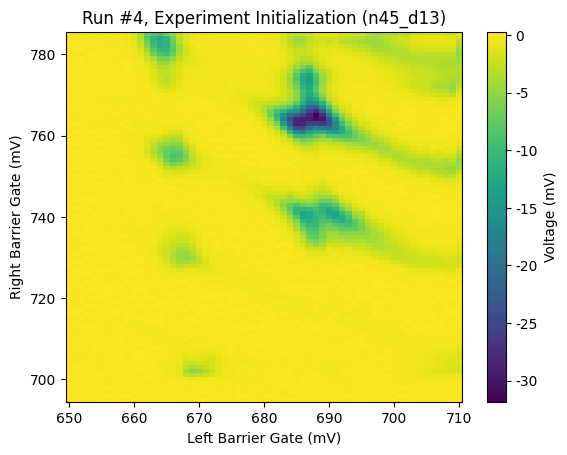

[]

In [8]:
db_file =  "c:\\Users\\coher\\Desktop\\noise1\\noise2\\n45_d13_2024-09-25\\experiments_n45_d13_2024-09-25.db"

LB_data, RB_data, I_data = get_data_from_qcodes_db(
    db_file,
    4,
    plot=True
)

extract_bias_point(
    LB_data,
    RB_data,
    I_data * QD_FET_Tuner.preamp_sensitivity,
    minAngleDeg = -60,
    maxAngleDeg = -40,
    threshold=10,
    minLineLength = 50,
    maxLineGap=250,
    debug=False,
    plot_results=True
)

In [9]:
bias_point = {'LB': 0.675, 'RB': 0.75}

# Coulomb Blockade

2024-09-25 18:47:28,294 - utils - INFO setting voltage configuration: {'LB': 0.675, 'RB': 0.75}
2024-09-25 18:47:28,784 - utils - INFO setting P to 0.5 V
2024-09-25 18:47:31,802 - utils - ATTEMPT sweeping gate P from 0.5 V to -0.5 V
Starting experimental run with id: 5. Using 'qcodes.dataset.dond'


  0%|          | 0/201 [00:00<?, ?it/s]

2024-09-25 18:47:46,566 - utils - COMPLETE 



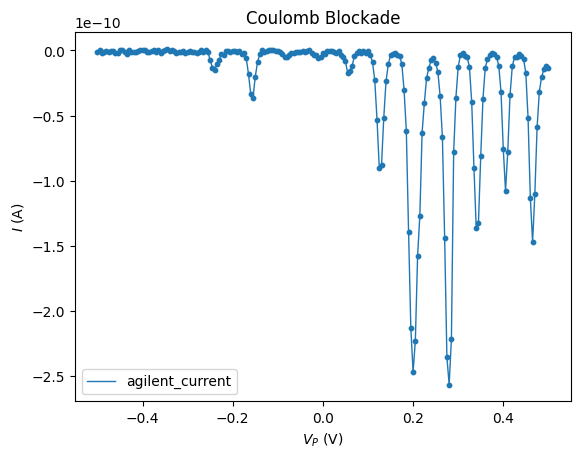

In [10]:
df, axes = QD_FET_Tuner.coulomb_blockade(
    gate='P', 
    gate_bounds=(0.5, -0.5), 
    dV=0.005,
    voltage_configuration = bias_point, 
)

Extract $\underset{\tilde{V}_P}{\mathrm{argmax}}\ G_{SD}$

In [ ]:
# QD_FET_Tuner.bias_ohmic(ohmic="S", V=0.01)
# print(QD_FET_Tuner._get_drain_current())

high: {'P': 0.27, 'conductance': 1.4582000808645792e-07}
medium: {'P': 0.335, 'conductance': 8.17299839637458e-08}
low: {'P': -0.165, 'conductance': 2.3268149255229233e-08}


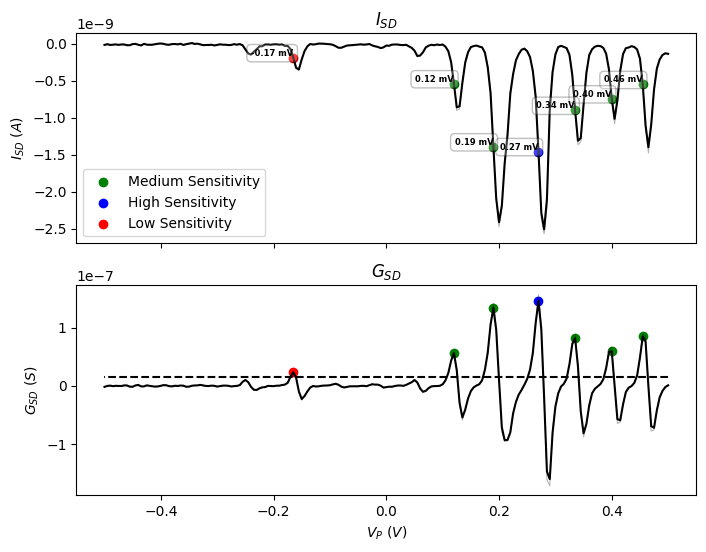

In [11]:
results = QD_FET_Tuner.extract_max_conductance_point(
    df,
    plot_process=True,
    sigma=0.5
)
for key, value in results.items():
    print(f"{key}: {value}")

# 5. Coulomb Diamonds

In [ ]:
QD_FET_Tuner.bias_ohmic(ohmic="S", V=0.01)

In [ ]:
df, cd_axes = QD_FET_Tuner.coulomb_diamonds(
    ohmic='S', 
    gate='P', 
    ohmic_bounds=(-0.5,0.5), #V
    gate_bounds=(0.2,-0.35), #V
    delay=0.1,
    dV_gate=0.002, 
    dV_ohmic=0.002,
    voltage_configuration=bias_point,
)

Extract lever arm, $\alpha$, at $\tilde{V}_{P}$

In [ ]:
P_data, S_data, I_data = get_data_from_qcodes_db(
    db_file,
    7,
    plot=True
)

In [ ]:
crop_left = 100
crop_right = -70

miner = Miner(
    gate_data=P_data[crop_left:crop_right],
    ohmic_data=S_data[:] * 1e-2,
    current_data=I_data[:, crop_left:crop_right] * 1e-8,
    epsR = 3.9,
    oxide_thickness=10e-9,
    binary_threshold=1.15,
    blur_sigma=3.,
    blur_kernel=(3,3)

)
diamond = miner.extract_diamonds(debug=True)

In [ ]:
miner.plot_diamonds()

In [ ]:
statistics = miner.get_statistics()

# Current Trace

In [16]:
QD_FET_Tuner.drain_mm_device.NPLC(1)
QD_FET_Tuner._smoothly_set_voltage_configuration({"P": -0.1}) # HIGH
# QD_FET_Tuner._smoothly_set_voltage_configuration({"P": -0.42}) #LOW
# QD_FET_Tuner._smoothly_set_voltage_configuration({"P": -0.26}) #CB

2024-09-25 18:56:37,060 - utils - INFO Running current trace for 100 seconds
Starting experimental run with id: 8. 


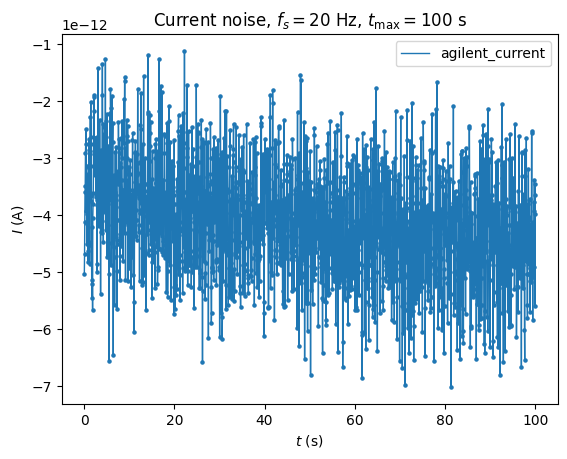

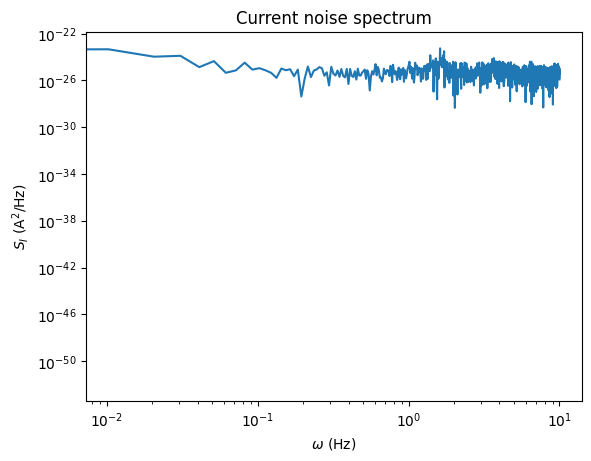

In [17]:
df = QD_FET_Tuner.current_trace(
    f_sampling=20, #Hz
    t_capture=100, #s 
    plot_psd=True,
    meas_name="zero_current",
    # voltage_configuration={"P":0.1}
)

In [ ]:
db_file =  "c:\\Users\\coher\\Desktop\\noise1\\n45_d13_2024-09-25\\experiments_n45_d13_2024-09-25.db"


qc.dataset.initialise_or_create_database_at(db_file)
# tutorial_exp = qc.dataset.load_or_create_experiment(
#     experiment_name="Initialization",
#     sample_name="n45_d13"
# )

dataset = qc.dataset.load_by_run_spec(experiment_name='Initialization', captured_run_id=12)
qc.dataset.plot_dataset(dataset)


In [ ]:
print(len(df))

# Ground Device

In [ ]:
QD_FET_Tuner.ground_device()

# DATABASE VIEWER

In [ ]:
db_file = "c:\\Users\\coher\\Desktop\\noise1\\noise2\\n45_d13_2024-09-25\\experiments_n45_d13_2024-09-25.db"
import IPython.lib.backgroundjobs as bg
from plottr.apps import inspectr

jobs = bg.BackgroundJobManager()
jobs.new(inspectr.main, db_file)

In [ ]:
db_file = "c:\\Users\\coher\\Desktop\\noise1\\noise2\\n45_d13_2024-09-25\\experiments_n45_d13_2024-09-25.db"

import qcodes as qc
import sys, os
import matplotlib.pyplot as plt

qc.dataset.initialise_or_create_database_at(db_file)

dataset = qc.dataset.load_by_run_spec(experiment_name='Initialization', captured_run_id=10)
qc.dataset.plot_dataset(dataset)
df = dataset.to_pandas_dataframe().reset_index()

In [ ]:
print(df)

In [ ]:
# import skimage
# from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
# from skimage.feature import canny
# from skimage.draw import line as draw_line
# from skimage import data
# import matplotlib.cm as cm


# range_RB = (0.615,0.747)
# range_LB = (0.533,0.631)
# filtered_df = df[
#     (df['sim900_volt_RB'] >= range_RB[0]) & (df['sim900_volt_RB'] <= range_RB[1]) &
#     (df['sim900_volt_LB'] >= range_LB[0]) & (df['sim900_volt_LB'] <= range_LB[1])
# ]

# cropped_img, Xdata, Ydata = convert_data_to_image(filtered_df)
# cropped_img = cropped_img[:,:,0]
# edges = canny(cropped_img,sigma=0.5, low_threshold=0.1*np.iinfo(np.uint8).max, high_threshold=0.3 * np.iinfo(np.uint8).max)
# lines = probabilistic_hough_line(edges, threshold=0, line_length=3,
#                                  line_gap=0)
# # Generating figure 2
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# ax = axes.ravel()

# ax[0].imshow(cropped_img, cmap=cm.gray, origin='lower', extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],)
# ax[0].set_title('Input image')

# ax[1].imshow(edges, cmap=cm.gray, origin='lower',  extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],)
# ax[1].set_title('Masked Canny edges')

# potential_points = {}
# angles_data = []
# slopes_data = []
# for line in lines:
#     p0_pixel, p1_pixel = line
#     p0, p1 = pixel_polygon_to_image_units(line, filtered_df)

#     dy =  (p1[1]-p0[1])
#     dx = (p1[0]-p0[0])
#     if dx == 0:
#         continue
#     m = dy/dx
#     theta = np.arctan(m)*(180/np.pi)
#     if theta > -40 or theta < -60:
#         continue
#     angles_data.append(theta)
#     slopes_data.append(m)
#     midpoint_pixel = (np.array(p0_pixel) + np.array(p1_pixel))/2
#     midpoint_units = (np.array(p0) + np.array(p1))/2
#     # print(midpoint)
#     midpoint = midpoint.astype(int)
#     current_at_midpoint = filtered_df['agilent_volt'].to_numpy().reshape(len(Xdata), len(Ydata))[midpoint[0],midpoint[1]]
#     potential_points[tuple(midpoint_units)] = current_at_midpoint

#     ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
#     ax[1].scatter([midpoint_units[0]],[midpoint_units[1]], marker='*',s=50)
#     ax[0].plot((p0[0], p1[0]), (p0[1], p1[1]))
#     ax[0].scatter([midpoint_units[0]],[midpoint_units[1]], marker='*',s=50)
    
# # ax[1].set_xlim((0, cropped_img.shape[1]))
# # ax[1].set_ylim((cropped_img.shape[0], 0))
# ax[1].set_title('Probabilistic Hough')
# ax[2].hist(angles_data, bins=2*int(np.sqrt(len(slopes_data))))
# ax[2].set_xlabel(r"$\theta^\circ$")
# ax[2].set_ylabel(r"$f$")
# # ax[2].hist(angles_data)
# # ax[0].set_axis_off()
# ax[1].set_axis_off()

In [ ]:
# print(potential_points)
# max_key = np.array(max(potential_points, key=potential_points.get))
# print("Key with the highest value:", max_key)
# bias_point = {Xdata.name: max_key[0], Ydata.name: max_key[1]}
# I = filtered_df['agilent_volt'].to_numpy().reshape(len(Ydata), len(Xdata))
# plt.imshow(I, extent=[Xdata.min(), Xdata.max(), Ydata.min() , Ydata.max()],origin='lower')
# plt.scatter(*max_key, marker='*', c='r')
# plt.ylabel(Ydata.name)
# plt.xlabel(Xdata.name)
# plt.colorbar()
# plt.show()


# print(f"Bias point: {bias_point}")